In [10]:
from pathlib import Path
import copy
from tqdm import tqdm

import torch
import pyscf
import numpy as np
import opt_einsum as oe
import matplotlib.pyplot as plt

from cadft.utils import Grid
from cadft import CC_DFT_DATA, Mol
from cadft.utils import gen_basis

In [11]:
mol = "butadiene"
distance = 0.0000

molecular = copy.deepcopy(Mol[mol])
molecular[0][1] += distance

dft2cc = CC_DFT_DATA(
    molecular,
    name="test",
    basis="STO-3G",
    if_basis_str=True,
)

mf = pyscf.scf.RHF(dft2cc.mol)
mf.kernel()
print(mf.make_rdm1().shape)

(26, 26)


In [12]:
mycc = pyscf.cc.CCSD(mf)
mycc.kernel()
dm1_cc = mycc.make_rdm1(ao_repr=True)
dm2_cc = mycc.make_rdm2(ao_repr=True)
e_cc = mycc.e_tot

mdft = pyscf.scf.RKS(dft2cc.mol)
mdft.xc = "b3lyp"
mdft.kernel()
e_dft = mdft.e_tot
dm1_dft = mdft.make_rdm1(ao_repr=True)

grids = Grid(dft2cc.mol)
coords = grids.coords
weights = grids.weights
ao_2 = pyscf.dft.numint.eval_ao(dft2cc.mol, coords, deriv=2)
ao_0 = ao_2[0, :, :]
ao_value = ao_2[:4, :, :]
ao_2_diag = ao_2[4, :, :] + ao_2[7, :, :] + ao_2[9, :, :]

rho_dft = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_dft, xctype="GGA")
rho_cc = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_cc, xctype="GGA")

rho_dft_grids = grids.vector_to_matrix(rho_dft[0])
rho_cc_grids = grids.vector_to_matrix(rho_cc[0])

In [13]:
# data = np.load(f"../data/grids_mrks/data_{mol}_cc-pCVDZ_0_1_{distance:.4f}.npz")
data = np.load(
    f"../data/grids_mrks/data_{mol}_cc-pCVDZ_0_1_{distance:.4f}.npz"
)
# data = np.load(
#     f"/run/user/1000/gvfs/sftp:host=hkqai/home/chenzihao/workdir/cadft/data/grids_mrks/data_{mol}_cc-pcvqz_0_1_{distance:.4f}.npz"
# )

In [14]:
for i in data.keys():
    print(i)

dm_cc
dm_inv
rho_cc
rho_inv
weights
vxc
vxc_b3lyp
exc
exc_real
exc_tr_b3lyp
exc1_tr_b3lyp
exc_tr
coords_x
coords_y
coords_z


1


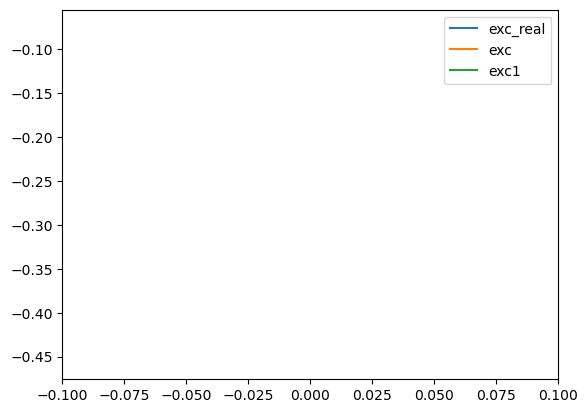

In [15]:
# exc_real = data["exc_over_dm_cc_grids"]
exc_real = data["exc_real"]
exc = data["exc_tr_b3lyp"]
exc1 = data["exc1_tr_b3lyp"]
# vxc = data["vxc"]
# vxc_b3lyp = data["vxc_b3lyp"]

index_ = np.where(
    (np.abs(coords[:, 1] + 5.745029803506404e-05) < 1e-4)
    & (np.abs(coords[:, 2]) < 1e-5)
)
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y11 = (grids.matrix_to_vector(exc_real))[index_][sort_]
y12 = (grids.matrix_to_vector(exc))[index_][sort_]
y13 = (grids.matrix_to_vector(exc1))[index_][sort_]
# y21 = (grids.matrix_to_vector(vxc))[index_][sort_]
# y22 = (grids.matrix_to_vector(vxc_b3lyp))[index_][sort_]

plt.plot(x, y11, label="exc_real")
plt.plot(x, y12, label="exc")
plt.plot(x, y13, label="exc1")
# plt.plot(x, y21, label="vxc")
# plt.plot(x, y22, label="vxc_b3lyp", linestyle="--")

# plt.xlim(-2.5, 2.5)
plt.xlim(-0.1, 0.1)
# plt.xlim(-2.1, -1.9)
# plt.xlim(-5, 5)
# plt.ylim(-5, 2.5)

plt.legend(loc="best")
print(len(x))

ValueError: x and y arrays must have a length of at least 3

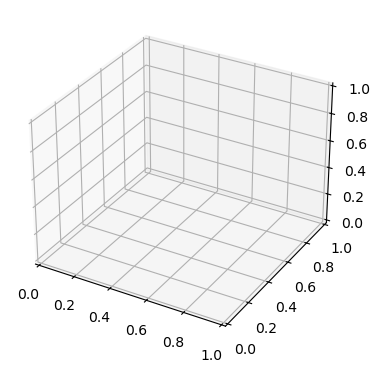

In [17]:
index_ = np.where((np.abs(coords[:, 2]) < 1e-10))
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y = coords[:, 1][index_][sort_]
# z11 = (grids.matrix_to_vector(exc))[index_][sort_]
z12 = (grids.matrix_to_vector(exc_real))[index_][sort_]
# z2 = (grids.matrix_to_vector(vxc))[index_][sort_]

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
# ax.plot_trisurf(x, y, z11, label="exc")
ax.plot_trisurf(x, y, z12, label="exc_real")
# ax.plot_trisurf(x, y, z2, label="vxc")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
# ax.set_zlim(-5, 5)
# plt.xlim(1.13, 1.155)

# plt.legend(loc='upper right')
print(len(x))

In [13]:
import torch

torch.cuda.mem_get_info()[0] // 8 // 140**4

1